<a href="https://colab.research.google.com/github/dallinmoore/DATA_5610_Deep_Learning/blob/main/Homework/project_2/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA 5610 - Project 2 - Facial Recognition Model


Dallin Moore


In [1]:
import os
import shutil
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Loading Images

In [2]:
!unzip -qq me.zip -d me_images

In [3]:
# Load "me" images from folder
me_dir = pathlib.Path("me_images")
me_image_paths = [str(path) for path in me_dir.glob("*.jpg")]

In [4]:
# Load LFW dataset as "not_me" images
builder = tfds.builder("lfw")
builder.download_and_prepare()
lfw_dataset = builder.as_dataset(split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/lfw/incomplete.LTTURJ_0.1.1/lfw-train.tfrecord*...:   0%|          | 0/132…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.1. Subsequent calls will reuse this data.


In [5]:
# run with less images to establish pipeline (total LFW dataset contains ~10,000 images)
lfw_dataset = lfw_dataset.take(1000)

In [6]:
def load_my_image(image_path):
    # Decode the string path tensor to a normal string
    image_path = image_path.numpy().decode('utf-8')

    # Open the image using PIL
    img = Image.open(image_path)

    # Resize to match LFW size (250x250x3)
    img = img.resize((250, 250))

    # Convert to numpy array and ensure it has 3 channels
    img_array = np.array(img)
    if len(img_array.shape) == 2:  # If grayscale
        img_array = np.stack([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[2] == 4:  # If RGBA
        img_array = img_array[:, :, :3]

    # Return image with proper shape and label
    return img_array.astype(np.uint8), "me"

# Create a dataset from your images
me_dataset = tf.data.Dataset.from_tensor_slices(me_image_paths)
me_dataset = me_dataset.map(
    lambda x: tf.py_function(
        load_my_image,
        [x],
        [tf.uint8, tf.string]
    )
)

# Format to match the LFW dataset structure
me_dataset = me_dataset.map(
    lambda image, label: {
        "image": image,
        "label": label
    }
)

# Set the output shapes explicitly to avoid unknown shape issues
me_dataset = me_dataset.map(
    lambda x: {
        "image": tf.ensure_shape(x["image"], [250, 250, 3]),
        "label": tf.ensure_shape(x["label"], [])
    }
)

# Use the LFW dataset
not_me_dataset = lfw_dataset.map(
    lambda x: {
        "image": tf.ensure_shape(x["image"], [250, 250, 3]),
        "label": tf.ensure_shape(x["label"], [])
    }
)

# Combine datasets
combined_dataset = me_dataset.concatenate(not_me_dataset)

# Shuffle the dataset
shuffled_dataset = combined_dataset.shuffle(buffer_size=10000)

In [7]:
# Convert to the format needed for training (image, label pairs)
def prepare_for_training(data_dict):
    # Normalize image to [0, 1] range
    image = tf.cast(data_dict["image"], tf.float32) / 255.0

    # Convert label to binary (1 for "me", 0 for others)
    label = tf.cast(tf.equal(data_dict["label"], "me"), tf.int32)

    return image, label

training_dataset = shuffled_dataset.map(prepare_for_training)

# Create training and validation splits
dataset_size = tf.data.experimental.cardinality(training_dataset).numpy()
train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

train_dataset = training_dataset.take(train_size)
val_dataset = training_dataset.skip(train_size).take(val_size)

# Batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Created training dataset with {train_size} samples")
print(f"Created validation dataset with {val_size} samples")


Created training dataset with 844 samples
Created validation dataset with 211 samples


## Model

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model

def create_my_model():
    # Load VGG16 pretrained on ImageNet, excluding the top fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
    base_model.trainable = False  # Freeze the base model to keep pretrained weights

    # Define the input layer
    inputs = tf.keras.Input(shape=(250, 250, 3))

    # Pass the input through the base VGG16 model
    x = base_model(inputs, training=False)

    # Add custom layers on top of VGG16
    x = layers.Flatten()(x)  # Flatten the output of VGG16
    x = layers.Dense(512, activation='relu')(x)  # Dense layer with ReLU
    x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

    # Create the full model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and summarize the model
model = create_my_model()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Define callbacks
callbacks = [
    # Early stopping to prevent overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,  # Stop if no improvement for 3 epochs
        restore_best_weights=True
    ),
    # Reduce learning rate when validation loss plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce learning rate by half
        patience=2,
        min_lr=1e-6  # Minimum learning rate
    ),
    # Save the best model during training
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,  # Start with 10, increase if needed
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1  # Show training progress
)

# Print a message when training is complete
print("Training completed!")

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8517 - loss: 1.8367

27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8547 - loss: 1.8120 - val_accuracy: 1.0000 - val_loss: 1.8733e-05 - learning_rate: 0.0010
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 355ms/step - accuracy: 0.9928 - loss: 0.0270 - val_accuracy: 1.0000 - val_loss: 4.4753e-09 - learning_rate: 0.0010
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step - accuracy: 1.0000 - loss: 8.8807e-05 - val_accuracy: 1.0000 - val_loss: 6.1402e-05 - learning_rate: 0.0010
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 1.0000 - loss: 1.8790e-04 - val_accuracy: 1.0000 - val_loss: 5.2105e-08 - learning_rate: 5.0000e-04
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 402ms/step - accuracy: 1.0000 - loss: 1.5435e-06 - val_accuracy: 1.0000 - val_loss: 1.8697e-07 - learning_rate: 5.0000e-04
Training completed!


## Testing

### Create Test Set

In [10]:
!unzip -qq me_test.zip -d me_test_images

In [11]:
me_test_dir = pathlib.Path("me_test_images")
me_test_image_paths = [str(path) for path in me_test_dir.glob("*.jpg")]

# Create a dataset from the new "me" test images
me_test_dataset = tf.data.Dataset.from_tensor_slices(me_test_image_paths)
me_test_dataset = me_test_dataset.map(
    lambda x: tf.py_function(
        load_my_image,  # Reusing your existing load_my_image function
        [x],
        [tf.uint8, tf.string]
    )
)

# Format to match the LFW dataset structure
me_test_dataset = me_test_dataset.map(
    lambda image, label: {
        "image": tf.ensure_shape(image, [250, 250, 3]),
        "label": tf.ensure_shape(label, [])
    }
)

In [12]:
lfw_full_dataset = builder.as_dataset(split="train")
# Skip the first 1,000 used in training/validation, take 100 more
not_me_test_dataset = lfw_full_dataset.skip(1000).take(100)

# Ensure shape consistency for "not_me" test images
not_me_test_dataset = not_me_test_dataset.map(
    lambda x: {
        "image": tf.ensure_shape(x["image"], [250, 250, 3]),
        "label": tf.ensure_shape(x["label"], [])
    }
)

In [13]:
# Combine test datasets
test_dataset = me_test_dataset.concatenate(not_me_test_dataset)

# Shuffle the test dataset
test_dataset = test_dataset.shuffle(buffer_size=120)  # 20 "me" + 100 "not_me"

# Prepare test dataset for evaluation
test_dataset = test_dataset.map(prepare_for_training)  # Reusing your prepare_for_training function

# Batch the test dataset
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Calculate test set size
test_size = tf.data.experimental.cardinality(test_dataset).numpy() * BATCH_SIZE
print(f"Created test dataset with approximately {test_size} samples")


Created test dataset with approximately 128 samples


### Evaluate Model on Test Set

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.9683 - loss: 0.1535
Test Loss: 0.1183
Test Accuracy: 0.9754


Found 3 misclassifications in the test set.


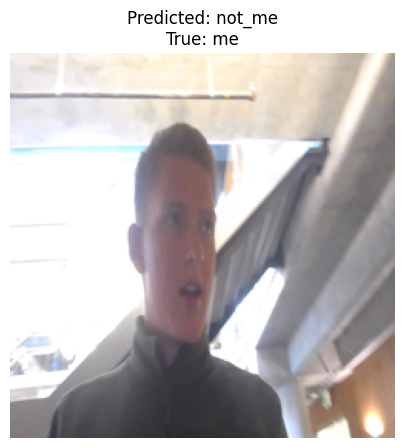

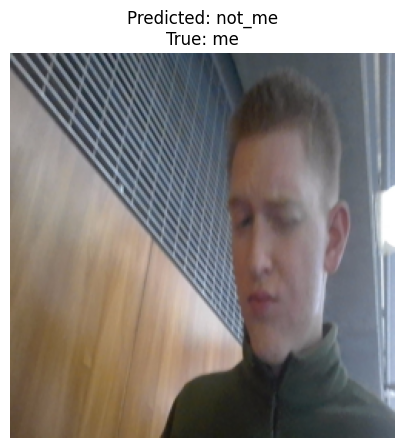

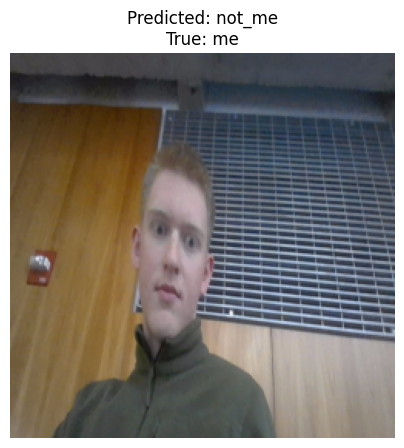

In [15]:
# Accumulate misclassifications across all batches
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

for batch in test_dataset:
    test_images, test_labels = batch  # Unpack the batch
    predictions = model.predict(test_images, verbose=0)  # Predict on the batch, suppress output

    for i in range(len(test_images)):
        predicted_label = "me" if predictions[i][0] > 0.5 else "not_me"
        true_label = "me" if test_labels[i].numpy() == 1 else "not_me"

        # If prediction is incorrect, store the image, true label, and predicted label
        if predicted_label != true_label:
            misclassified_images.append(test_images[i].numpy())
            misclassified_true_labels.append(true_label)
            misclassified_pred_labels.append(predicted_label)

# Display up to 5 misclassifications
max_errors_to_show = 5
num_errors = len(misclassified_images)

if num_errors > 0:
    print(f"Found {num_errors} misclassifications in the test set.")
    for i in range(min(max_errors_to_show, num_errors)):
        plt.figure(figsize=(5, 5))
        plt.imshow(misclassified_images[i])
        plt.title(f"Predicted: {misclassified_pred_labels[i]}\nTrue: {misclassified_true_labels[i]}")
        plt.axis('off')
        plt.show()
else:
    print("No misclassifications found in the test set.")

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np

all_test_labels = []
all_predictions = []
all_pred_probs = []

for batch in test_dataset:
    test_images, test_labels = batch
    predictions = model.predict(test_images, verbose=0)
    all_test_labels.extend(test_labels.numpy())
    all_predictions.extend([1 if p > 0.5 else 0 for p in predictions])
    all_pred_probs.extend(predictions.flatten())

all_test_labels = np.array(all_test_labels)
all_predictions = np.array(all_predictions)
all_pred_probs = np.array(all_pred_probs)

precision = precision_score(all_test_labels, all_predictions)
recall = recall_score(all_test_labels, all_predictions)
f1 = f1_score(all_test_labels, all_predictions)
conf_matrix = confusion_matrix(all_test_labels, all_predictions)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
roc_auc = roc_auc_score(all_test_labels, all_pred_probs)
precision_curve, recall_curve, _ = precision_recall_curve(all_test_labels, all_pred_probs)
pr_auc = auc(recall_curve, precision_curve)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("Confusion Matrix:")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

Precision: 1.0000
Recall: 0.8636
F1-Score: 0.9268
Specificity: 1.0000
ROC-AUC: 1.0000
PR-AUC: 1.0000
Confusion Matrix:
TN: 100, FP: 0, FN: 3, TP: 19


### Testing With New Data

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Me


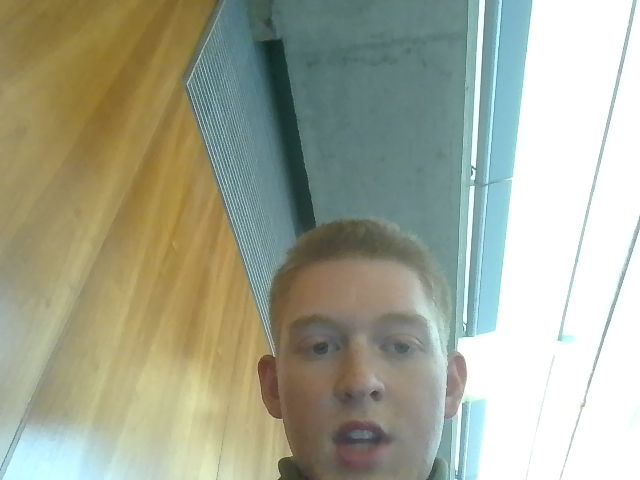

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Prediction: Me


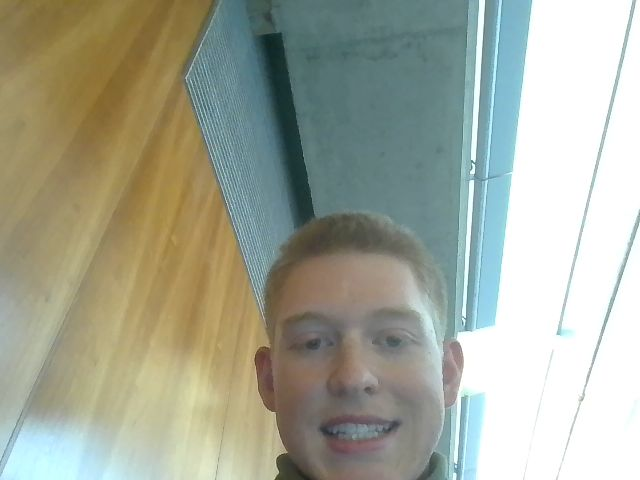

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Prediction: Me


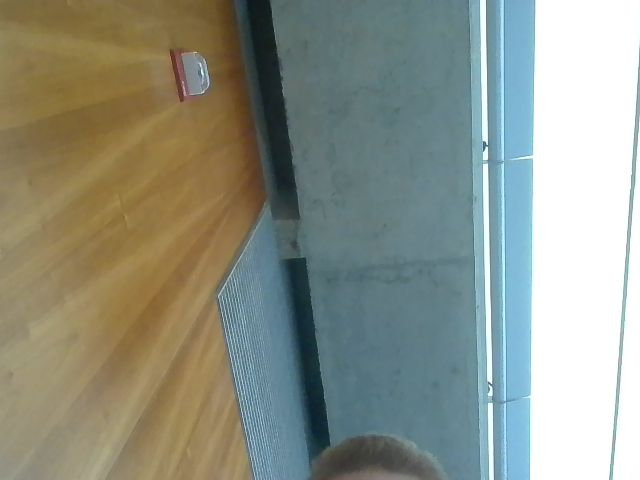

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Not Me


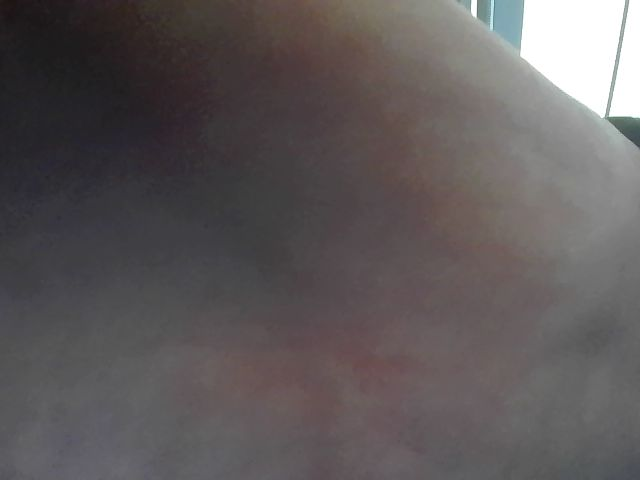

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Prediction: Not Me


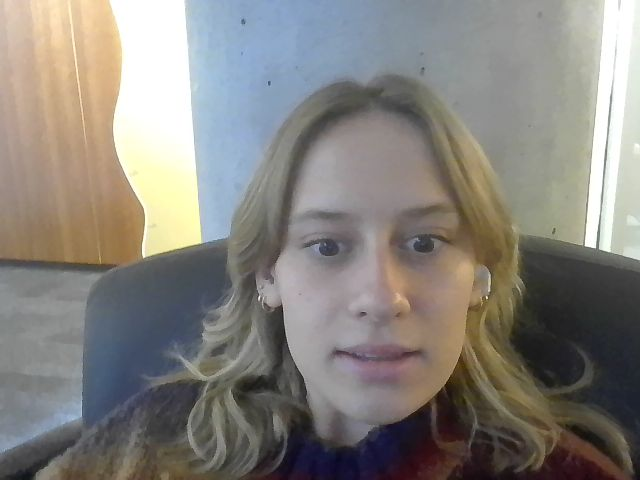

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Prediction: Not Me


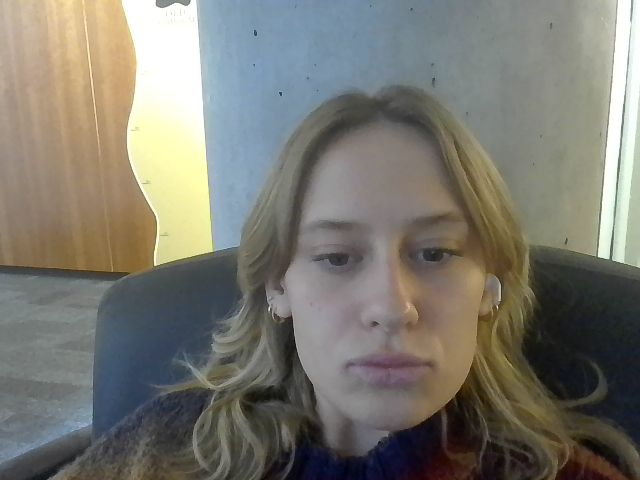

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Prediction: Not Me


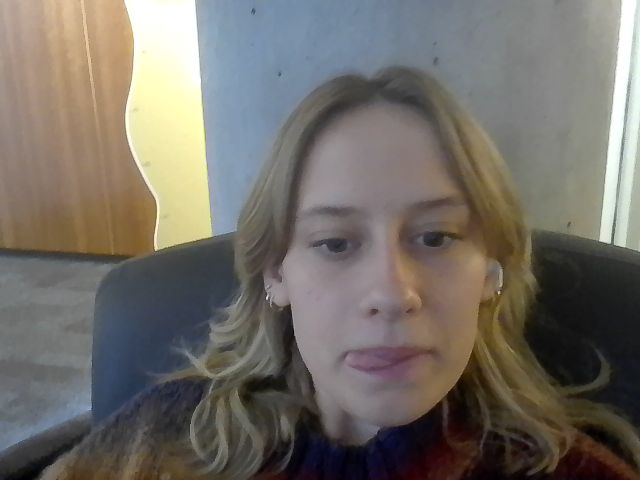

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Prediction: Not Me


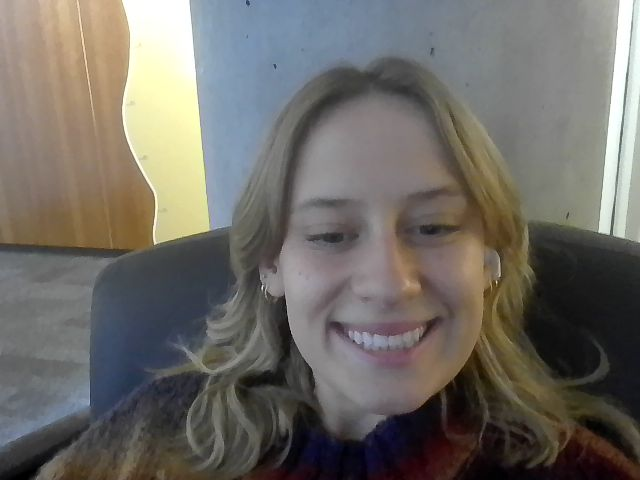

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Prediction: Not Me


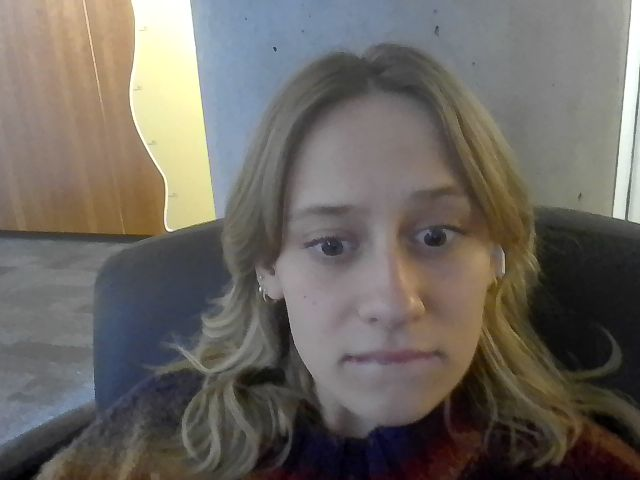

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Prediction: Not Me


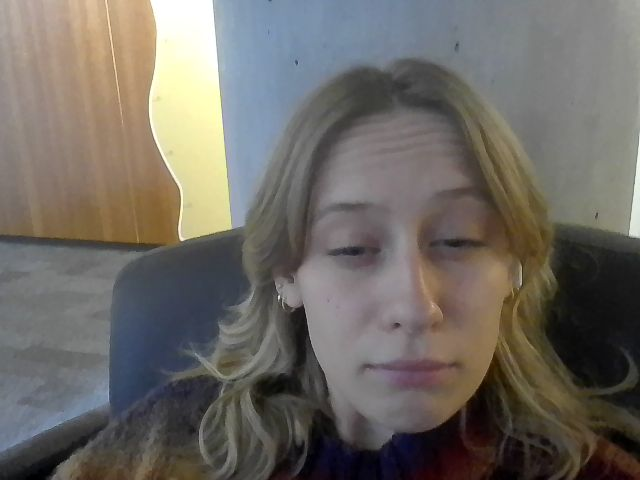

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [39]:
from IPython.display import Image as IPythonImage # don't confuse PIL.Image with IPython.display.

while True:
    try:
        filename = take_photo()
        img = tf.keras.utils.load_img(filename, target_size=(250, 250))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch

        # Make the prediction
        predictions = model.predict(img_array)

        # Interpret the prediction (assuming a binary classification)
        if predictions[0][0] > 0.5:
            print("Prediction: Me")
        else:
            print("Prediction: Not Me")

        # Show the image which was just taken.
        display(IPythonImage(filename))
    except Exception as err:
        # Errors will be thrown if the user does not have a webcam or if they do not
        # grant the page permission to access it.
        print(str(err))
        break